In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import viz

from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import linregress

colors = viz.plotting_style()
lin_colors = list(colors.values())
greys = sns.color_palette('Greys', 6)

plt.style.use('style.mpl')

# Code generating Figures 3-4
Figure 2 is entirely diagrammatic. 
Figures 3-4 use the convex optimization approaches to analyze our unified model. 
To generate the CSV files used here, run "do_optimization_analyses.py".

Figure 3 shows that our model has an intrinsic maximum growth rate. The model enables us to understand how metabolism and physiology are interconnected via the phi variables. 

Figure 4 interrogates metabolic flexibility by showing that our default model configuration has a finite ZC range over which growth is feasible. Altering this range -- moving it, changing its endpoints -- affects the growth rates achievable, i.e. describes a set of tradeoffs. 

In [19]:
# Load model sensitivity analyses
phi_df = pd.read_csv('../output/linear_optimization/fix_lambda.csv')
var_ZCred_df = pd.read_csv('../output/linear_optimization/fix_ZCred.csv')
var_phi_red_df = pd.read_csv('../output/linear_optimization/fix_phi_red.csv')
var_ZCB_df = pd.read_csv('../output/linear_optimization/fix_ZCred_ZCB.csv')

var_S5_df = pd.read_csv('../output/linear_optimization/fix_ZCred_S5.csv')
var_S4_df = pd.read_csv('../output/linear_optimization/fix_ZCred_S4.csv')
var_S3_df = pd.read_csv('../output/linear_optimization/fix_ZCred_S3.csv')
var_ZCB_df = pd.read_csv('../output/linear_optimization/fix_ZCred_ZCB.csv')

# Used in SI figures
var_phi_O_df = pd.read_csv('../output/linear_optimization/fix_phi_O.csv')
var_g_ana_df = pd.read_csv('../output/linear_optimization/fix_g_ana.csv')
var_g_red_df = pd.read_csv('../output/linear_optimization/fix_g_red.csv')

In [ ]:
def make_ZCred_range_df(var_df, var_name):
    """Generate a data frame of ZCred ranges for each value of a variable.

    Assumes the only thing varying in the DF are ZCred and the variable chosen.

    Args:
        var_df: a data frame of model runs with the variable of interest
        var_name: the name of the variable of interest in var_df

    Returns:
        A data frame with the range of ZCred values for each value of the
        variable of interest, as well as the maximum and minimum lambda_hr.
    """
    mask = np.logical_and(var_df.lambda_hr > 0.001,
                          var_df['opt.max_phi_H_set'] == True)
    # phi_H maximum is *unset* when we allow the optimizer to set phi_H
    masked = var_df[mask]
    # calculate the range of viable ZCred values as well as max/min lambda_hr
    max_ZCred = masked.groupby(var_name).agg({'ZCred': 'max'})
    min_ZCred = masked.groupby(var_name).agg({'ZCred': 'min'})
    max_lambda = masked.groupby(var_name).agg({'lambda_hr': 'max'})
    min_lambda = masked.groupby(var_name).agg({'lambda_hr': 'min'})

    ZCred_range = max_ZCred - min_ZCred
    max_ZCred_range = var_df.ZCred.max() - var_df.ZCred.min()

    # make a data frame from the above
    my_df = pd.DataFrame(dict(ZCred_range=ZCred_range.ZCred,
                              ZCred_min=min_ZCred.ZCred,
                              ZCred_max=max_ZCred.ZCred,
                              max_lambda_hr=max_lambda.lambda_hr,
                              min_lambda_hr=min_lambda.lambda_hr))
    # when the inferred range is the same as the max range,
    # then we don't really know what the range is
    my_df[my_df.ZCred_range == max_ZCred_range] = np.nan
    # when the max equals the max observed, we don't know the range
    my_df[my_df.ZCred_max == var_df.ZCred.max()] = np.nan
    # when the min equals the min observed, we don't know the range
    my_df[my_df.ZCred_min == var_df.ZCred.min()] = np.nan

    return my_df

In [ ]:
ZCred_range_by_S3 = make_ZCred_range_df(var_S3_df, 'S3')
ZCred_range_by_S4 = make_ZCred_range_df(var_S4_df, 'S4')
ZCred_range_by_S5 = make_ZCred_range_df(var_S5_df, 'S5')
ZCred_range_by_ZCB = make_ZCred_range_df(var_ZCB_df, 'ZCB')

# Fit a line to the ZCred_range vs. max lambda
tradeoff_reg_S4 = linregress(ZCred_range_by_S4.ZCred_range, ZCred_range_by_S4.max_lambda_hr)
tradeoff_S3_smooth = sm.nonparametric.lowess(ZCred_range_by_S3.min_lambda_hr, ZCred_range_by_S3.ZCred_range)
tradeoff_S4_smooth = sm.nonparametric.lowess(ZCred_range_by_S4.max_lambda_hr, ZCred_range_by_S4.ZCred_range)
tradeoff_S5_smooth = sm.nonparametric.lowess(ZCred_range_by_S5.max_lambda_hr, ZCred_range_by_S5.ZCred_range)
tradeoff_ZCB_smooth = sm.nonparametric.lowess(ZCred_range_by_ZCB.max_lambda_hr, ZCred_range_by_ZCB.ZCred_range)

0.0001
estimated lambda_max: 2.592
actual lambda_max: 2.28702680515414


/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_95152/1300373751.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


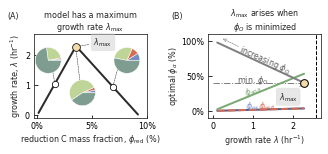

In [14]:
# Figure 3 -- facets of maximum growth rates in our model
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4.75, 2.25))

# lambda as a function of phi_red
plt.sca(axs[0])
#mask = var_phi_red_df.S4.isin([0.5, 1.0, 1.5])
mask = var_phi_red_df.S4 == 1.0
masked = var_phi_red_df[mask]
pal = [colors[c] for c in 'light_green,green,dark_green'.split(',')]
sns.lineplot(data=masked,
             x='reduction_phi',
             y='lambda_hr', color=greys[-1],
             legend=False)

# show pie charts for select points
phi_names = 'oxidation_phi,reduction_phi,anabolism_phi,phi_O'.split(',')
low_phi_red = masked.iloc[15]
low_phi_red.lambda_hr
hi_phi_red = masked.iloc[-24]
hi_phi_red.lambda_hr
max_phi_red = masked.loc[masked.lambda_hr.idxmax()]
plt.scatter([low_phi_red.reduction_phi, hi_phi_red.reduction_phi],
            [low_phi_red.lambda_hr, hi_phi_red.lambda_hr], 
            color='w', marker='o', s=40, edgecolor='k', 
            lw=0.75, zorder=10)

max_idxs = masked.groupby('S4').lambda_hr.idxmax().values
lambda_max = masked.loc[max_idxs].lambda_hr.max()
phi_red_argmax = masked.loc[max_idxs].reduction_phi.values[0]
sns.scatterplot(data=masked.loc[max_idxs],
                x='reduction_phi',
                y='lambda_hr',
                color=colors['light_yellow'], marker='o', s=60, edgecolor='k',
                lw=0.75, zorder=10, legend=False)

# annotate the point where lambda_max is found
bbox = dict(boxstyle="round", fc=greys[1], ec=greys[1], lw=0.5, alpha=0.5)
arrowprops = dict(
    arrowstyle="-", linestyle='--', 
    facecolor=greys[-1], edgecolor=greys[-1], lw=0.5)
plt.annotate('$\lambda_{\mathrm{max}}$', xy=(phi_red_argmax, lambda_max), xytext=(phi_red_argmax+0.025, lambda_max+0.15),
             textcoords='data', fontsize=8, ha='center', va='center', color=greys[-1],
             annotation_clip=False, arrowprops=arrowprops, bbox=bbox)

plt.ylabel(r'growth rate, $\lambda$ (hr$^{-1}$)')
plt.xlabel(r'reduction C mass fraction, $\phi_{\mathrm{red}}$ (%)')
plt.ylim(-0.1, 2.7)

# percent format the X axis
plt.xticks(np.arange(0, 0.11, 0.05))
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().xaxis.set_major_formatter(formatter)

# make an inset pie charts
inset_ax_positions = [
    [0.07, 0.5, 0.2, 0.2],
    [0.17, 0.3, 0.2, 0.2],
    [0.3, 0.5, 0.2, 0.2],
]
cs = [colors[c] for c in 'blue,red,light_green,dark_green'.split(',')]
my_labels = ['', '', '$\phi_{\mathrm{ana}}$', '$\phi_O$']
for i, phi_series in enumerate([low_phi_red, max_phi_red, hi_phi_red]):
    inset_pos = inset_ax_positions[i]
    ax_inset = fig.add_axes(inset_pos)
    phis = phi_series[phi_names].values
    assert round(phis.sum()) == 1.0
    ax_inset.pie(phis, colors=cs, wedgeprops=dict(lw=0.5, edgecolor='w'))
    

# reset the current axis to the main plot so we can use its coordinates
plt.sca(axs[0])
inset_center_pos_data = [
    (0.0125, 1.75),
    (0.04, 0.8),
    (0.075, 1.75),
]
for i, phi_series in enumerate([low_phi_red, max_phi_red, hi_phi_red]):
    # use annotate() to draw arrows from insets to points on the main plot
    bbox = dict(boxstyle="round,pad=0", fc="w", ec="w", lw=0, alpha=0)
    xy = phi_series.reduction_phi, phi_series.lambda_hr
    xytext = inset_center_pos_data[i]
    plt.annotate('', xy=xy, xytext=xytext,
                 textcoords='data', xycoords='data',
                 arrowprops=arrowprops, zorder=-1)

# phis as a function of lambda
plt.sca(axs[1])

# Estimate lambda_max from simple relationships
min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
print(g_ana)
est_lambda_max = 12*3600*g_ana*(1-min_phi_O)
lambda_max = phi_df.lambda_hr.max()
print('estimated lambda_max:', est_lambda_max)
print('actual lambda_max:', lambda_max)

# Line at min_phi_O
min_phi_O = 0.4
plt.plot([0, lambda_max], [min_phi_O, min_phi_O], 
         color='grey', ls='-.', lw=1)

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
cmap = dict(oxidation=colors['dark_blue'],
            reduction=colors['red'],
            anabolism=colors['green'],
            other='grey')
processes = 'oxidation,reduction,anabolism'.split(',')
process_labels = dict(
    oxidation=r'$\phi_{\mathrm{ox}}$',
    reduction=r'$\phi_{\mathrm{red}}$',
    anabolism=r'$\phi_{\mathrm{ana}}$',
    other=r'$\phi_O$')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    legend_label = process_labels[label]
    c = cmap[label]
    ls = '--' if label == 'reduction' else '-'
    plt.plot(x, phi_df[col], label=legend_label, color=c, ls=ls)
plt.scatter([lambda_max], [min_phi_O], color=colors['light_yellow'], edgecolor='k', marker='o', zorder=10, s=60)

labels = ["min. $\phi_{\mathrm{O}}$", "$\phi_{\mathrm{ana}}$", 
          "$\phi_{\mathrm{ox}}$", "$\phi_{\mathrm{red}}$"]
lcolors = [greys[-2], colors['green'], colors['blue'], colors['red']]
locs = [(1, 0.45, 0), (1, 0.3, 26), (1, 0.085, 3), (1.35, 0.086, 3)]
for label, c, loc in zip(labels, lcolors, locs):
    x,y,rotation = loc
    plt.text(x, y, label, ha='center', va='center', color=c,
             transform=plt.gca().transData, rotation=rotation, fontsize=8)

# use annotate to draw an arrow towards the top-left from the increasing phi_o label
bbox = dict(boxstyle="round,pad=0", fc="w", ec="w", lw=0, alpha=0)
arrowprops = dict(
    arrowstyle="->", linestyle='--', 
    facecolor=greys[-2], edgecolor=greys[-2], lw=0.5)
plt.annotate('increasing $\phi_{\mathrm{O}}$', xy=(0.2, 1.04), xytext=(1.3, 0.73), textcoords='data', rotation=-24,
             fontsize=8, ha='center', va='center', color=greys[-2], annotation_clip=True, arrowprops=arrowprops, bbox=bbox)

# annotate the point where lambda_max is found
bbox = dict(boxstyle="round", fc=greys[1], ec=greys[1], lw=0.5, alpha=0.5)
arrowprops = dict(
    arrowstyle="-", linestyle='--', 
    facecolor=greys[-1], edgecolor=greys[-1], lw=0.5)
plt.annotate('$\lambda_{\mathrm{max}}$', xy=(lambda_max, min_phi_O), xytext=(lambda_max-0.4, min_phi_O-0.2), textcoords='data',
             fontsize=8, ha='center', va='center', color=greys[-1], annotation_clip=False, arrowprops=arrowprops, bbox=bbox)

plt.axvline(est_lambda_max, color='k', ls='--', lw=1) 
#plt.text(est_lambda_max-0.02, 0.3, r'$\lambda_{\mathrm{max}} \approx \gamma_{\mathrm{ana}}(1-\phi_O)$', ha='right', va='center', rotation=90, fontsize=9)
plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'optimal $\phi_\alpha$ (%)')   
#plt.legend(loc=1)
plt.ylim(-0.1, 1.1)
# percent format the Y axis
plt.yticks(np.arange(0, 1.1, 0.5))
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

titles = [
    'model has a maximum\ngrowth rate $\lambda_{\mathrm{max}}$',
    '$\lambda_{\mathrm{max}}$ arises when\n$\phi_O$ is minimized',
]
for title, ax in zip(titles, axs):
    ax.set_title(title)

plt.figtext(0.05, 0.86, '(A)', fontsize=8)
plt.figtext(0.53, 0.86, '(B)', fontsize=8)

plt.tight_layout()
plt.savefig('../output/Fig3_growth_rate.pdf', facecolor='white', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Peeking at the data for S5 (nu^a_ana) to make a correct label.
ZCred_range_by_S5.pivot_table(index='S5', values='ZCred_range,max_lambda_hr'.split(',')).head(n=5)
# growth rate increases while ZC_red range decreases as anabolic ATP cost |S5| decreases

,ZCred_range,max_lambda_hr
S5,,
-1.4,4.30,1.919981
-1.3,4.15,1.956206
-1.2,4.00,1.993825
-1.1,3.85,2.032919
-1.0,3.65,2.073577


In [16]:
# Peeking at the data for S4 (nu^a_red) to make a correct label.
ZCred_range_by_S4.pivot_table(index='S4', values='ZCred_range,max_lambda_hr'.split(',')).head(n=5)
# growth rate increases while ZC_red range decreases as reductive ATP yield S4 increases

,ZCred_range,max_lambda_hr
S4,,
0.15,3.50,1.727954
0.20,3.00,1.885044
0.25,2.70,1.993800
0.30,2.50,2.073555
0.35,2.35,2.133259


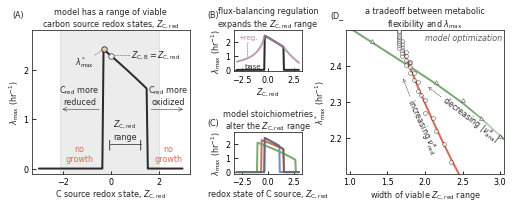

In [17]:
# Fig. 4 -- consequences of changing the C source ZC with all else fixed
mosaic_text = "AABDD\nAACDD"
fig, axs = plt.subplot_mosaic(mosaic_text, figsize=(7.24, 3), 
                              gridspec_kw={'width_ratios': [1, 1, 1.2, 1, 1]})
my_arrowprops = dict(arrowstyle='-', ls='--', lw=0.5, color=greys[-2])

# Panel showing features of the "baseline" model.
# 1. A range of viable ZCred values, no growth outside. 
# 2. Growth rate maximizing ZCred value is slightly more reduced than ZCB.
plt.sca(axs["A"])

# Select ZCB == 0, which is the default model
mask = var_ZCB_df['ZCB'].abs() < 1e-6 
masked = var_ZCB_df[mask]
ZCB_val = masked.ZCB.values[0]
no_phi_H = masked[
    masked['opt.max_phi_H_set'] == True]
plt.plot(no_phi_H.ZCred, no_phi_H.lambda_hr, color=greys[-1], label='$Z_{{C,B}}$ = {0:.1f}'.format(ZCB_val+1e-6))

mask2 = np.logical_and(mask, var_ZCB_df.lambda_hr > 0.01)
mask2 = np.logical_and(mask2, var_ZCB_df['opt.max_phi_H_set'] == True)
masked2 = var_ZCB_df[mask2]
idx_max = masked2.lambda_hr.idxmax()
idx_min = masked2.lambda_hr.idxmin()
lmax = masked2.loc[idx_max].lambda_hr
lmin = masked2.loc[idx_min].lambda_hr
ZCred_max = masked2.loc[idx_max].ZCred
ZCred_min = masked2.loc[idx_min].ZCred
plt.scatter([ZCred_max], [lmax], color=colors['light_yellow'],
            edgecolor='k', marker='o', zorder=10, s=30, lw=0.75, alpha=0.9)

# Highlight points where ZCred = ZCB
mask = np.logical_and(
    var_ZCB_df.ZCB == ZCB_val,
    (var_ZCB_df.ZCB - var_ZCB_df.ZCred).abs() < 0.01)
mask = np.logical_and(mask, var_ZCB_df['opt.max_phi_H_set'] == True)
lam_at_equal = var_ZCB_df[mask].lambda_hr.values[0]
sns.scatterplot(data=var_ZCB_df[mask],
                x='ZCred',
                y='lambda_hr',
                color='w', marker='o',
                s=30, edgecolor=greys[-1], alpha=0.9,
                lw=0.75, zorder=10, legend=False)

# approx range of ZCred values for coli C sources. 
plt.axvspan(-2.1, 2, color=greys[-3], alpha=0.15, zorder=-10)
plt.text(-1.3, 0.15, "no\ngrowth", color=colors['red'], ha='center', fontsize=8)
plt.text(2.4, 0.15, "no\ngrowth", color=colors['red'], ha='center', fontsize=8)
plt.text(-1.3, 1.3, "$\mathrm{C}_{\mathrm{red}}$ more\nreduced", color=greys[-1], ha='center', fontsize=8)
plt.text(2.42, 1.3, "$\mathrm{C}_{\mathrm{red}}$ more\noxidized", color=greys[-1], ha='center', fontsize=8)
plt.annotate("", xy=(-2.1, 1.2), xytext=(-0.4, 1.2), xycoords='data', textcoords='data', ha='right',
             arrowprops=dict(arrowstyle='->', ls='-', lw=0.5, color=greys[-1]))
plt.annotate("", xy=(3.1, 1.2), xytext=(1.6, 1.2), xycoords='data', textcoords='data', ha='right',
             arrowprops=dict(arrowstyle='->', ls='-', lw=0.5, color=greys[-1]))
plt.annotate("$Z_{\mathrm{C,B}} = Z_{\mathrm{C,red}}$", xy=(0, lam_at_equal), xytext=(2.9, 2.3),
             ha='right', va='center', fontsize=8, bbox=dict(pad=-1, fc='w', ec='w', lw=0, alpha=0),
             arrowprops=my_arrowprops)
plt.annotate("$\lambda^*_{\mathrm{max}}$", xy=(ZCred_max, lmax), xytext=(ZCred_max-0.4, lmax-0.25),
             ha='right', va='center', fontsize=8, bbox=dict(pad=-1, fc='w', ec='w', lw=0, alpha=0),
             arrowprops=my_arrowprops)
# mark the ZCred range
# max lambda at lower end of range
xmin, xmax = ZCred_max + 0.25, ZCred_min - 0.25  
xmid = np.mean([xmin, xmax])
plt.text(xmid, 0.6, '$Z_{\mathrm{C,red}}$\nrange',
         color=greys[-1], ha='center', fontsize=8)
# line with end caps
plt.plot([xmin, xmax], [0.5, 0.5], 
         color=greys[-1], ls='-', lw=0.75)
anno_args = dict(ha='center', va='center', fontsize=10, color=greys[-1])
plt.annotate("|", xy=(xmin, 0.5), **anno_args)
plt.annotate("|", xy=(xmax, 0.5), **anno_args)

         
plt.ylabel('$\lambda_{\mathrm{max}}$ (hr$^{-1}$)')
plt.xlabel('C source redox state, $Z_{\mathrm{C,red}}$')  
plt.yticks(np.arange(0, 2.91, 1))
plt.ylim(-0.1, 2.8)

plt.sca(axs['B'])
phi_H_included = var_ZCred_df[
    var_ZCred_df['opt.max_phi_H_set'] == False]
no_phi_H = var_ZCred_df[
    var_ZCred_df['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.ZCred, no_phi_H.lambda_hr, color=greys[-1],
         label=r'baseline model'.format(min_phi_O))
plt.plot(phi_H_included.ZCred, phi_H_included.lambda_hr,
         color=colors['purple'], ls='-', alpha=0.8,
         label=r'+ATP homeostasis', zorder=10)
# approx range of ZCred values for coli C sources. 
# plt.axvspan(-2.1, 2, color=greys[-3], alpha=0.15, zorder=-10)
plt.text(-1.5, 0.25, 'base', color=greys[-1],
         va='center', ha='center', fontsize=7)
plt.annotate('+reg.', xy=(-2, 0.8), xytext=(-1.9, 2.3),
             arrowprops=my_arrowprops,
             bbox=dict(boxstyle='round', pad=0, 
                       fc='w', ec='w', lw=0, alpha=0),
             fontsize=7, ha='center', va='center',
             color=colors['purple'])

ZCred_xlabel = '$Z_{\mathrm{C,red}}$'
plt.xlabel(ZCred_xlabel)
plt.yticks(np.arange(0, 2.91, 1))
plt.ylim(-0.1, 2.8)
plt.ylabel(r'$\lambda_{\mathrm{max}}$ (hr$^{-1}$)')

# Panel showing what happens to range of viable ZCred values 
# when we alter models stoichiometries S3 and S4 a bit. 
# default S3 = +0.5 ATP, S4 = +1.0 ATP, S5 = -0.3 ATP/C
# for the glucose + O2 respiration model. 
plt.sca(axs['C'])

# Plot one S4 variation
S4_val = 0.5
masked = var_S4_df[(var_S4_df['S4'] - S4_val).abs() < 1e-6]
no_phi_H = masked[
    masked['opt.max_phi_H_set'] == True]
plt.plot(no_phi_H.ZCred, no_phi_H.lambda_hr, color=colors['red'], label='$S_4$ = {0:.1f}'.format(S4_val))

# Plot one S3 variation
S3_val = 0.75
masked = var_S3_df[var_S3_df['S3'] == S3_val]
no_phi_H = masked[
    masked['opt.max_phi_H_set'] == True]
plt.plot(no_phi_H.ZCred, no_phi_H.lambda_hr, color=colors['blue'], label='$S_3$ = {0:.2f}'.format(S3_val+0))

# Plot one S5 variation
S5_val = -1.0
masked = var_S5_df[(var_S5_df.S5-S5_val).abs() < 1e-6]
no_phi_H = masked[
    masked['opt.max_phi_H_set'] == True]
plt.plot(no_phi_H.ZCred, no_phi_H.lambda_hr, color=colors['green'], label='$S_5$ = {0:.2f}'.format(S5_val+0))

# Plot the default model
S4_val = 1.0
masked = var_S4_df[(var_S4_df['S4'] - S4_val).abs() < 1e-6]
no_phi_H = masked[
    masked['opt.max_phi_H_set'] == True]
plt.plot(no_phi_H.ZCred, no_phi_H.lambda_hr, color=greys[-2], label='$S_4$ = {0:.1f}'.format(S4_val), alpha=0.7)

plt.ylabel('$\lambda_{\mathrm{max}}$ (hr$^{-1}$)')
plt.xlabel('redox state of C source, $Z_{\mathrm{C,red}}$')
plt.legend(loc=2).set_visible(False)
plt.yticks(np.arange(0, 2.91, 1))
plt.ylim(-0.1, 2.8)
#plt.xlim(-2, 2)

plt.sca(axs['D'])
sns.scatterplot(data=ZCred_range_by_S4,
                x='ZCred_range',
                y='max_lambda_hr',
                color='w', marker='o',
                s=15, edgecolor='k', alpha=0.7,
                lw=0.5, zorder=10, legend=False)
sns.scatterplot(data=ZCred_range_by_S5,
                x='ZCred_range',
                y='max_lambda_hr',
                color='w', marker='^',
                s=15, edgecolor='k', alpha=0.7,
                lw=0.5, zorder=10, legend=False)

plt.plot(tradeoff_S4_smooth[:,0], tradeoff_S4_smooth[:,1],
         color=colors['red'], zorder=-10, ls='-', alpha=1)
plt.plot(tradeoff_S5_smooth[:,0], tradeoff_S5_smooth[:,1],
         color=colors['green'], zorder=-110, ls='-', alpha=1)

plt.xlim(0.95, 3.05)
plt.ylim(2.1, 2.5)
plt.yticks(np.arange(2.2, 2.401, 0.1))
plt.ylabel('$\lambda^*_{\mathrm{max}}$ (hr$^{-1}$)')
plt.xlabel('width of viable $Z_{\mathrm{C,red}}$ range')
plt.text(0.99, 0.98, 'model optimization', transform=plt.gca().transAxes,
         ha='right', va='top', color=greys[-2], fontsize=8, style='italic')

# convert these to annotations with arrows
# annotate the point where lambda_max is found
bbox = dict(boxstyle="round", fc='w', ec='w', pad=0, lw=0.5, alpha=0.5)
ap = dict(arrowstyle="->", linestyle='--', facecolor=greys[-1], edgecolor=greys[-1], lw=0.5)
plt.annotate(r'decreasing $|\nu^{a}_{\mathrm{ana}}|$', xy=(2.02, 2.345), xytext=(3.01, 2.18), textcoords='data',
             rotation=-37, fontsize=8, ha='right', va='bottom', color=greys[-1],
             annotation_clip=False, arrowprops=ap, bbox=bbox)
plt.annotate(r'increasing $\nu^{a}_{\mathrm{red}}$', xy=(1.7, 2.37), xytext=(2.2, 2.15), textcoords='data',
             rotation=-65, fontsize=8, ha='right', va='bottom', color=greys[-1],
             annotation_clip=False, arrowprops=ap, bbox=bbox)

titles = [('A', 'model has a range of viable\ncarbon source redox states, $Z_{\mathrm{C,red}}$'),
          ('B', 'flux-balancing regulation\nexpands the $Z_{\mathrm{C,red}}$ range'),
          ('C', 'model stoichiometries\nalter the $Z_{\mathrm{C,red}}$ range'),
          ('D', 'a tradeoff between metabolic\nflexibility and $\lambda_{\mathrm{max}}$'),
          ]
for label, title in titles: 
    axs[label].set_title(title)

plt.figtext(0.03, 0.9, '(A)', fontsize=8)
plt.figtext(0.405, 0.9, '(B)', fontsize=8)
plt.figtext(0.405, 0.4, '(C)', fontsize=8)
plt.figtext(0.64, 0.9, '(D_', fontsize=8)

plt.tight_layout()
plt.savefig('../output/Fig4_metabolic_flexibility.pdf', facecolor='white', dpi=300, bbox_inches='tight')
plt.show()

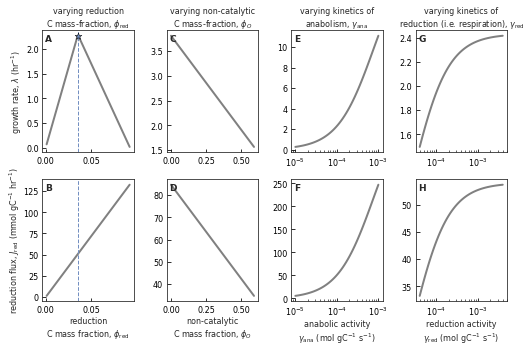

In [20]:
# Supplementary figure focusing on respiratory rates
# TODO: add variable stoichiometry, e.g. S4, to these panels
# TODO: calculate CUE and plot that as well
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(7.24, 5))
flat_axs = axs.flatten(order='F')

# Left panel: varying phi_red
# Model can use ATP homeostasis to maximize growth
plt.sca(axs[0,0])
# File was made with variable S4 -- use default value of 1 ATP/e-
mask = var_phi_red_df.S4 == 1.0
masked_phi_red_df = var_phi_red_df[mask]

max_idx = masked_phi_red_df.lambda_hr.idxmax()
plt.plot(masked_phi_red_df.reduction_phi, masked_phi_red_df.lambda_hr, color='grey')
plt.scatter(masked_phi_red_df.reduction_phi[max_idx], masked_phi_red_df.lambda_hr[max_idx],
            color=colors['blue'], marker='*', zorder=10, s=50, edgecolor='k', lw=0.5)
plt.axvline(masked_phi_red_df.reduction_phi[max_idx], color=colors['blue'], ls='--', lw=1)
plt.ylabel(r'growth rate, $\lambda$ (hr$^{-1}$)')
plt.title('varying reduction\nC mass-fraction, $\phi_{\mathrm{red}}$')
plt.sca(axs[1,0])
plt.plot(masked_phi_red_df.reduction_phi, masked_phi_red_df.reduction_flux*3.6e6,
         color='grey')
plt.axvline(masked_phi_red_df.reduction_phi[max_idx], color=colors['blue'], ls='--', lw=1)
plt.ylabel(r'reduction flux, $J_{\mathrm{red}}$ (mmol gC$^{-1}$ hr$^{-1}$)')
plt.xlabel('reduction\nC mass fraction, $\phi_{\mathrm{red}}$')

# Left panel: varying phi_O
# Model can use ATP homeostasis to maximize growth
plt.sca(axs[0,1])
plt.plot(var_phi_O_df.phi_O, var_phi_O_df.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying non-catalytic\nC mass-fraction, $\phi_O$')
plt.sca(axs[1,1])
plt.plot(var_phi_O_df.phi_O, var_phi_O_df.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('non-catalytic\nC mass fraction, $\phi_O$')

# Middle panels: varying anabolism gamma
# TODO: narrow range here so growth rates don't balloon as much
mask = var_g_ana_df['opt.max_phi_H_set'] == False
masked = var_g_ana_df[mask]

plt.sca(axs[0,2])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\nanabolism, $\gamma_{\mathrm{ana}}$')
plt.sca(axs[1,2])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('anabolic activity\n$\gamma_{\mathrm{ana}}$ (mol gC$^{-1}$ s$^{-1}$)')

# Right panels: varying anabolism gamma
mask = var_g_red_df['opt.max_phi_H_set'] == False
masked = var_g_red_df[mask]

plt.sca(axs[0, 3])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\n reduction (i.e. respiration), $\gamma_{\mathrm{red}}$')
plt.sca(axs[1, 3])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('reduction activity\n$\gamma_{\mathrm{red}}$ (mol gC$^{-1}$ s$^{-1}$)')

for label, ax in zip("ABCDEFGH", flat_axs):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=9, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('../output/FigSX_max_Jred.png', facecolor='white', bbox_inches='tight', dpi=300)

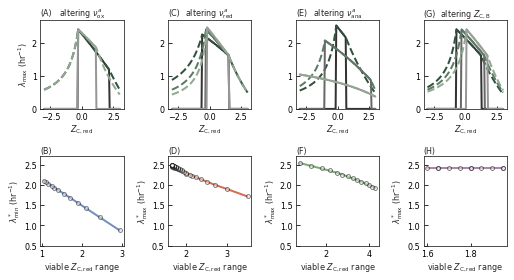

In [23]:
# Notice that phi_O increases as lambda decreases
mosaic = "ACEG\nBDFH"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(7.24, 4), sharey=False)
pal = sns.color_palette('Greys_r', n_colors=5)
greens = sns.color_palette('Greens_r', n_colors=5, desat=0.3)

# Variable S3 = oxidative ATP yield
plt.sca(axs['A'])
my_S3s = [0.25, 0.5, 0.75]
for i, S3 in enumerate(my_S3s):
    masked = var_S3_df[(var_S3_df['S3'] - S3).abs() < 1e-6]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCred, no_phi_H.lambda_hr, color=pal[i], label='$S_3$ = {0:.2f}'.format(S3+0))
    plt.plot(phi_H_included.ZCred, phi_H_included.lambda_hr, color=greens[i], ls='--')

# tradeoff plot for S3
plt.sca(axs['B'])
plt.scatter(ZCred_range_by_S3.ZCred_range, ZCred_range_by_S3.min_lambda_hr,
            alpha=0.5, color='w', edgecolor='k', s=15)
plt.plot(tradeoff_S3_smooth[:,0], tradeoff_S3_smooth[:,1], color=colors['blue'], zorder=-10)
plt.ylabel('$\lambda^*_{\mathrm{min}}$ (hr$^{-1}$)')

# Variable S4 = reductive ATP yield
plt.sca(axs['C'])
my_S4s = [0.5, 1, 1.5]
for i, S4 in enumerate(my_S4s):
    masked = var_S4_df[(var_S4_df['S4'] - S4).abs() < 1e-6]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCred, no_phi_H.lambda_hr, color=pal[i], label='$S_4$ = {0:.1f}'.format(S4))
    plt.plot(phi_H_included.ZCred, phi_H_included.lambda_hr, color=greens[i], ls='--')

# tradeoff plot for S4 
plt.sca(axs['D'])
plt.scatter(ZCred_range_by_S4.ZCred_range, ZCred_range_by_S4.max_lambda_hr, 
            alpha=0.5, color='w', edgecolor='k', s=15)
plt.plot(tradeoff_S4_smooth[:,0], tradeoff_S4_smooth[:,1], color=colors['red'], zorder=-10)
plt.ylabel('$\lambda^*_{\mathrm{max}}$ (hr$^{-1}$)')

# Variable S5 = anabolic ATP yield
plt.sca(axs['E'])
my_S5s = [-0.1, -1, -5]
for i, S5 in enumerate(my_S5s):
    masked = var_S5_df[(var_S5_df['S5'] - S5).abs() < 1e-6]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCred, no_phi_H.lambda_hr, color=pal[i], label='$S_5$ = {0:.2f}'.format(S3+0))
    plt.plot(phi_H_included.ZCred, phi_H_included.lambda_hr, color=greens[i], ls='--')
plt.legend(loc=2).set_visible(False)

# tradeoff plot for S5
plt.sca(axs['F'])
plt.scatter(ZCred_range_by_S5.ZCred_range, ZCred_range_by_S5.max_lambda_hr,
            alpha=0.5, color='w', edgecolor='k', s=15)
plt.plot(tradeoff_S5_smooth[:,0], tradeoff_S5_smooth[:,1], color=colors['green'], zorder=-10)
plt.ylabel('$\lambda^*_{\mathrm{max}}$ (hr$^{-1}$)')

# Variable ZCB
plt.sca(axs['G'])
ZCBs = np.array(sorted(var_ZCB_df.ZCB.unique()))
my_ZCBs = ZCBs[[ 1, 5, 9, ]]
for i, zcb in enumerate(my_ZCBs):
    masked = var_ZCB_df[(var_ZCB_df.ZCB - zcb).abs() < 1e-6]
    
    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCred, no_phi_H.lambda_hr, color=pal[i], label='$Z_{{C,B}}$ = {0:.1f}'.format(zcb+1e-6))
    plt.plot(phi_H_included.ZCred, phi_H_included.lambda_hr, color=greens[i], ls='--')

# tradeoff plot for ZCB
plt.sca(axs['H'])
plt.scatter(ZCred_range_by_ZCB.ZCred_range, ZCred_range_by_ZCB.max_lambda_hr,
            alpha=0.5, color='w', edgecolor='k', s=15)
plt.plot(tradeoff_ZCB_smooth[:,0], tradeoff_ZCB_smooth[:,1], color=colors['purple'], zorder=-10)
plt.ylabel('$\lambda^*_{\mathrm{max}}$ (hr$^{-1}$)')

for label in "ACEG":
    plt.sca(axs[label])
    plt.xlabel('$Z_{\mathrm{C,red}}$')
    if label == 'A':
        plt.ylabel('$\lambda_{\mathrm{max}}$ (hr$^{-1}$)')
    plt.ylim(0, 2.7)
for label in "BDFH":
    plt.sca(axs[label])
    plt.xlabel('viable $Z_{\mathrm{C,red}}$ range')
    plt.ylim(0.5, 2.7)

titles = dict(
    A=r'altering $\nu^{a}_{\mathrm{ox}}$',
    C=r'altering $\nu^{a}_{\mathrm{red}}$',
    E=r'altering $\nu^{a}_{\mathrm{ana}}$',
    G=r'altering $Z_{\mathrm{C,B}}$',
)
for label in "ABCDEFGH":
    plt.sca(axs[label])
    plt.title('({0})'.format(label), loc='left')
    plt.title(titles.get(label, ''), loc='center')

plt.tight_layout()
plt.savefig('../output/FigSX_model_change_stoich.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

In [24]:
# Enzymology figures -- data from Bar-Even et al. 2011
# run munge/munge_enzyme_data.py to generate this file.
enz_data = pd.read_csv('../data/enzymes/BarEven2011_compact_kinetics.csv')

,EC1,EC2,EC3,EC4,compound_ID,reaction_ID,direction,organism_ID,publication_ID,T,pH,KM_uM,kcat_s,module_ID,module_name,module_type
0,1,1,1,1,84,754,1,7,2819000,NaN,NaN,3400.0,NaN,NaN,NaN,NaN
1,1,1,1,1,84,754,1,7,6395900,NaN,NaN,85.0,NaN,NaN,NaN,NaN
2,1,1,1,1,84,754,1,8,6354100,NaN,NaN,217.0,NaN,NaN,NaN,NaN
3,1,1,1,1,84,754,1,9,3282500,NaN,NaN,2830.0,NaN,NaN,NaN,NaN


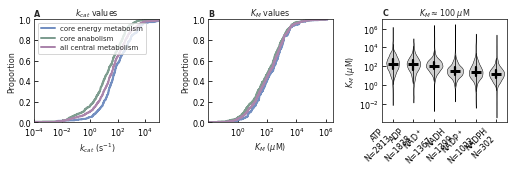

In [25]:
fig, axs = plt.subplots(ncols=3, figsize=(7.24, 2.5))
flat_axs = axs.flatten()

notnull = enz_data.kcat_s.notnull()
mask_primary_energy = np.logical_and(
    notnull, enz_data.module_type == 'Primary - Carbohydrate & Energy Metabolism')
mask_primary_biosyn = np.logical_and(
    notnull, enz_data.module_type == 'Primary - amino acids, fatty acids and nucleotides')
mask_primary_all = np.logical_or(mask_primary_energy, mask_primary_biosyn)
mask_secondary = np.logical_and(
    notnull, enz_data.module_type == 'Secondary')

sub_dfs = [enz_data[mask] for mask in [mask_primary_energy, mask_primary_biosyn, mask_primary_all]]
names = ['core energy metabolsm', 'core anabolism', 'all central metabolism']

# kcat plot
plt.sca(axs[0])
plt.xscale('log')
my_pal = [colors['blue'], colors['dark_green'], colors['purple']]
for i, (df, name) in enumerate(zip(sub_dfs, names)):
    sns.ecdfplot(df.kcat_s, label=name, color=my_pal[i])
    plt.xlabel('$k_{cat}$ (s$^{-1}$)')
plt.legend(loc=2, fontsize=7)
plt.title('$k_{cat}$ values')
plt.xlim((1e-4, 1e5))

# KM plot
plt.sca(axs[1])
plt.xscale('log')
for i, (df, name) in enumerate(zip(sub_dfs, names)):
    sns.ecdfplot(df.KM_uM, label=name, color=my_pal[i])
    plt.xlabel('$K_{M}}$ ($\mu$M)')
plt.title('$K_M$ values')

plt.sca(axs[2])
cpds = {
    2: 'ATP',
    8: 'ADP',
    3: 'NAD$^+$',
    4: 'NADH',
    6: 'NADP$^+$',
    5: 'NADPH',
}
cpd_order = list(cpds.keys())
sub_df = enz_data[enz_data.compound_ID.isin(cpds.keys())].copy()
sub_df['log_KM_uM'] = np.log10(sub_df.KM_uM)
counts = sub_df.groupby('compound_ID').agg({'KM_uM':'count'}).values.T[0].tolist()
medians = sub_df.groupby('compound_ID').agg({'KM_uM':'median', 'log_KM_uM':'median'})

@FuncFormatter
def my_formatter(x, pos):
     return r"10$^{{{0:0.0f}}}$".format(x)

greys = sns.color_palette('Greys', 6)
sns.violinplot(data=sub_df, x='compound_ID', y='log_KM_uM',
               order=cpd_order, color=greys[1], edgecolor='k', linewidth=0.5)
sns.stripplot(data=medians, x=medians.index, y='log_KM_uM', marker='_', s=10,
              order=cpd_order, color='k', linewidth=3, jitter=0)

xs = np.arange(6)
labels = [cpds[i] for i in cpd_order]
labels = ['{0}\nN={1}'.format(l, n) for l,n in zip(labels, counts)]
plt.xticks(xs, labels, rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('$K_M$ ($\mu$M)')
plt.gca().yaxis.set_major_formatter(my_formatter)

plt.title('$K_M \\approx 100$ $\\mu$M')

for label, ax in zip("ABCDEFGH", flat_axs):
    plt.sca(ax)
    plt.title(label, loc='left', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/FigSX_enzyme_kinetics.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()